In [1]:
!pip install scikit-learn pandas matplotlib seaborn

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

display(df.head())

Saving data.csv.xlsx to data.csv.xlsx


,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [3]:
X = df.drop(columns=['HiringDecision'])
y = df['HiringDecision']

In [4]:
male_df = df[df['Gender'] == 1]
female_df = df[df['Gender'] == 0]

In [5]:
male_train = male_df.sample(frac=0.8, random_state=42)
female_train = female_df.sample(frac=0.2, random_state=42)
train_df = pd.concat([male_train, female_train])
test_df = df.drop(train_df.index)
X_train = train_df.drop(columns=['HiringDecision'])
y_train = train_df['HiringDecision']

X_test = test_df.drop(columns=['HiringDecision'])
y_test = test_df['HiringDecision']


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print("Original X_train shape:", X_train.shape)
print("Scaled X_train shape:", X_train_scaled.shape)
print("Original X_test shape:", X_test.shape)
print("Scaled X_test shape:", X_test_scaled.shape)

Original X_train shape: (742, 10)
Scaled X_train shape: (742, 10)
Original X_test shape: (758, 10)
Scaled X_test shape: (758, 10)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8575197889182058

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       518
           1       0.82      0.70      0.76       240

    accuracy                           0.86       758
   macro avg       0.85      0.82      0.83       758
weighted avg       0.86      0.86      0.85       758



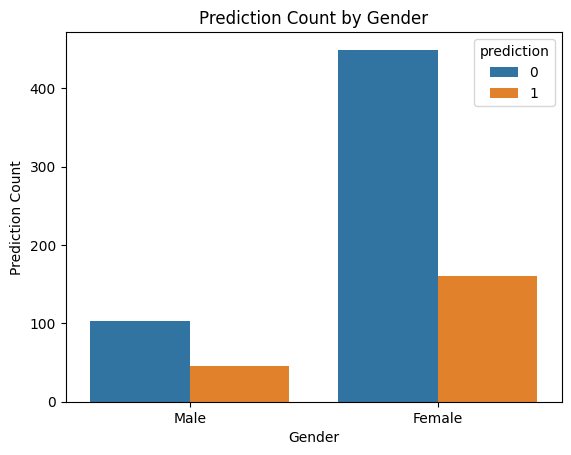

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

test_df = test_df.copy()
test_df = test_df.reset_index(drop=True)
test_df['Gender'] = X_test['Gender'].values  # Reattach Gender
test_df['prediction'] = y_pred
test_df['Gender'] = test_df['Gender'].map({1: 'Male', 0: 'Female'})
sns.countplot(data=test_df, x='Gender', hue='prediction')
plt.title("Prediction Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Prediction Count")
plt.show()


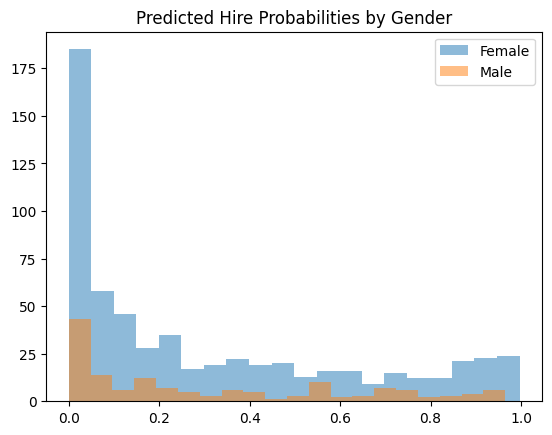

In [9]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of "Hire"
plt.hist(y_prob[test_df['Gender'] == 'Female'], bins=20, alpha=0.5, label='Female')
plt.hist(y_prob[test_df['Gender'] == 'Male'], bins=20, alpha=0.5, label='Male')
plt.legend()
plt.title("Predicted Hire Probabilities by Gender")
plt.show()


In [10]:
test_df.groupby('Gender')[['InterviewScore', 'SkillScore', 'ExperienceYears']].mean()


,InterviewScore,SkillScore,ExperienceYears
Gender,,,
Female,51.906557,52.009836,7.821311
Male,51.418919,52.547297,7.878378


In [11]:
test_df['Gender'].value_counts()


,count
Gender,
Female,610
Male,148


In [12]:
hire_rates = test_df.groupby('Gender')['prediction'].mean()
print("Hire rates by gender:")
print(hire_rates)

Hire rates by gender:
Gender
Female    0.263934
Male      0.304054
Name: prediction, dtype: float64


In [13]:
!pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.3 MB/s eta 0:00:00


In [14]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from sklearn.metrics import accuracy_score, recall_score

# Sensitive feature (Gender), prediction, and true label
y_true = test_df['HiringDecision']
y_pred = test_df['prediction']
sensitive_feature = test_df['Gender']  # Already "Male"/"Female" mapped

dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)

metric_frame = MetricFrame(metrics=selection_rate,
                           y_true=y_true,
                           y_pred=y_pred,
                           sensitive_features=sensitive_feature)

print("Fairness Metrics:")
print("Demographic Parity Difference:", round(dp_diff, 3))
print("Equal Opportunity Difference:", round(eo_diff, 3))
print("Selection Rate by Gender:\n", metric_frame.by_group)

Fairness Metrics:
Demographic Parity Difference: 0.04
Equal Opportunity Difference: 0.097
Selection Rate by Gender:
 Gender
Female    0.263934
Male      0.304054
Name: selection_rate, dtype: float64


In [15]:
from sklearn.metrics import confusion_matrix

cm_female = confusion_matrix(y_true[sensitive_feature == 'Female'], y_pred[sensitive_feature == 'Female'])
tn_f, fp_f, fn_f, tp_f = cm_female.ravel()

fpr_female = fp_f / (fp_f + tn_f)
tpr_female = tp_f / (tp_f + fn_f)

cm_male = confusion_matrix(y_true[sensitive_feature == 'Male'], y_pred[sensitive_feature == 'Male'])
tn_m, fp_m, fn_m, tp_m = cm_male.ravel()

fpr_male = fp_m / (fp_m + tn_m)
tpr_male = tp_m / (tp_m + fn_m)

manual_aod = ((fpr_female - fpr_male) + (tpr_female - tpr_male)) / 2

print(f"Manual Average Odds Difference: {manual_aod:.3f}")

Manual Average Odds Difference: -0.059


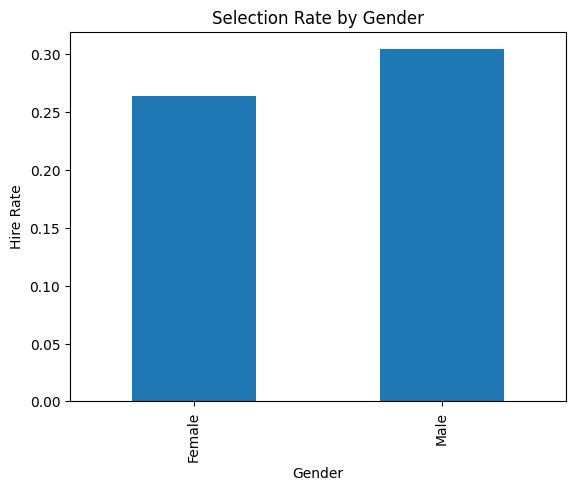

In [16]:
metric_frame.by_group.plot(kind='bar', title='Selection Rate by Gender')
plt.ylabel("Hire Rate")
plt.show()

In [17]:
!pip install shap

Feature0: Age
Feature1: Gender
Feature2: EducationLevel
Feature3: ExperienceYears
Feature4: PreviousCompanies
Feature5: DistanceFromCompany
Feature6: InterviewScore
Feature7: SkillScore
Feature8: PersonalityScore
Feature9: RecruitmentStrategy


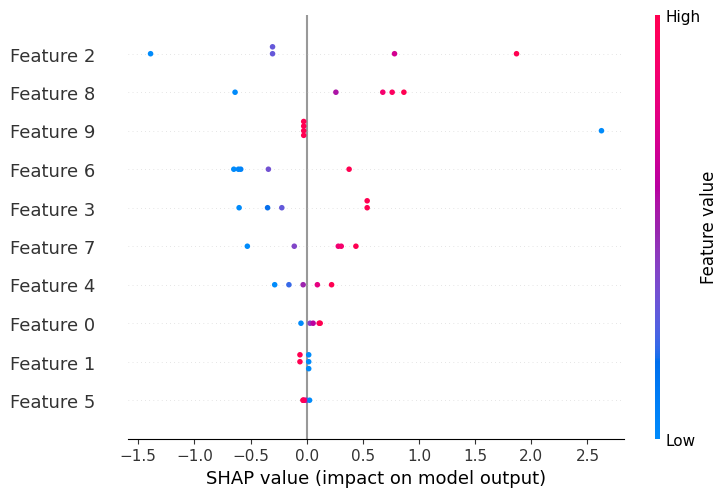

In [20]:
import shap

explainer = shap.Explainer(model, X_test_scaled)

test_df['prediction'] = y_pred
hire_indices = test_df[test_df['prediction'] == 1].index[:3]

nohire_indices = test_df[test_df['prediction'] == 0].index[:2]

selected_indices = hire_indices.tolist() + nohire_indices.tolist()

X_selected = X_test_scaled[selected_indices]
shap_values = explainer(X_selected)

for i, name in enumerate(X_train.columns):
    print(f"Feature{i}: {name}")

shap.plots.beeswarm(shap_values)


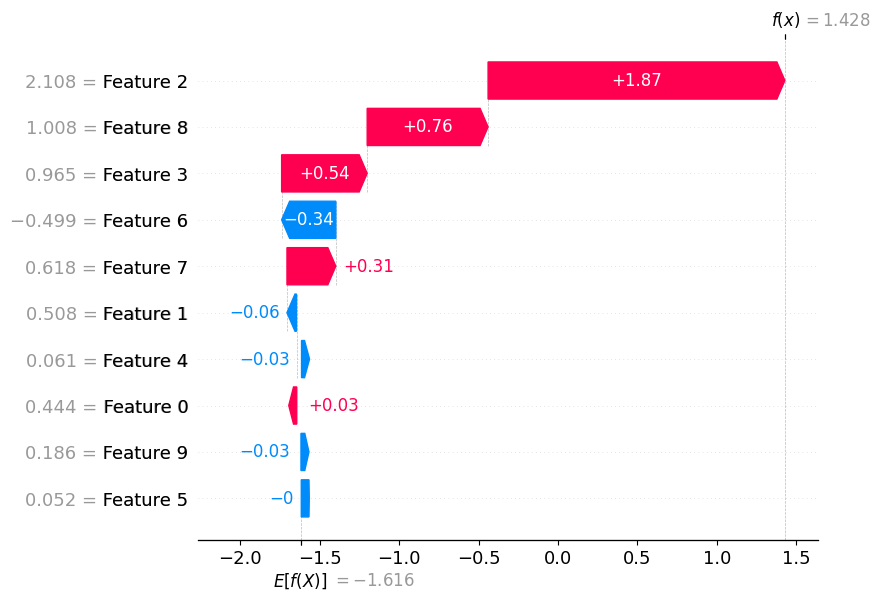

In [21]:
shap.plots.waterfall(shap_values[0])

## **Counterfactual Data Augmentation**

In [24]:
female_rows = train_df[train_df['Gender'] == 0].copy()

female_rows['Gender'] = 1

augmented_train_df = pd.concat([train_df, female_rows], ignore_index=True)
X_train_aug = augmented_train_df.drop(columns=['HiringDecision'])
y_train_aug = augmented_train_df['HiringDecision']

X_train_aug_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)



In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_aug = LogisticRegression(max_iter=1000)
model_aug.fit(X_train_aug_scaled, y_train_aug)

y_pred_aug = model_aug.predict(X_test_scaled)


print("Original Accuracy:", accuracy_score(y_test, y_pred))
print("After Mitigation Accuracy:", accuracy_score(y_test, y_pred_aug))



Original Accuracy: 0.8575197889182058
After Mitigation Accuracy: 0.8548812664907651


In [41]:
# Make sure indices match
test_df = test_df.reset_index(drop=True)
test_df['y_pred_aug'] = y_pred_aug

# Female
cm_female_aug = confusion_matrix(
    test_df.loc[test_df['Gender'] == 'Female', 'HiringDecision'],
    test_df.loc[test_df['Gender'] == 'Female', 'y_pred_aug']
)
tn_fa, fp_fa, fn_fa, tp_fa = cm_female_aug.ravel()
fpr_female_aug = fp_fa / (fp_fa + tn_fa)
tpr_female_aug = tp_fa / (tp_fa + fn_fa)

# Male
cm_male_aug = confusion_matrix(
    test_df.loc[test_df['Gender'] == 'Male', 'HiringDecision'],
    test_df.loc[test_df['Gender'] == 'Male', 'y_pred_aug']
)
tn_ma, fp_ma, fn_ma, tp_ma = cm_male_aug.ravel()
fpr_male_aug = fp_ma / (fp_ma + tn_ma)
tpr_male_aug = tp_ma / (tp_ma + fn_ma)

aod_aug = 0.5 * ((fpr_female_aug - fpr_male_aug) + (tpr_female_aug - tpr_male_aug))
print(f"Manual AOD After Counterfactual Augmentation: {aod_aug:.3f}")


Manual AOD After Counterfactual Augmentation: -0.066


In [42]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, selection_rate, MetricFrame

# BEFORE mitigation
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=test_df['Gender'])
eo_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=test_df['Gender'])

metric_frame = MetricFrame(metrics=selection_rate,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=test_df['Gender'])

# AFTER mitigation
dp_diff_aug = demographic_parity_difference(y_test, y_pred_aug, sensitive_features=test_df['Gender'])
eo_diff_aug = equalized_odds_difference(y_test, y_pred_aug, sensitive_features=test_df['Gender'])

metric_frame_aug = MetricFrame(metrics=selection_rate,
                               y_true=y_test,
                               y_pred=y_pred_aug,
                               sensitive_features=test_df['Gender'])

# PRINT RESULTS
print("Fairness Metrics BEFORE Mitigation:")
print("Demographic Parity Difference:", round(dp_diff, 3))
print("Equal Opportunity Difference:", round(eo_diff, 3))
print("Selection Rate by Gender:\n", metric_frame.by_group)
print("\n")

print("Fairness Metrics AFTER Mitigation:")
print("Demographic Parity Difference:", round(dp_diff_aug, 3))
print("Equal Opportunity Difference:", round(eo_diff_aug, 3))
print("Selection Rate by Gender:\n", metric_frame_aug.by_group)


Fairness Metrics BEFORE Mitigation:
Demographic Parity Difference: 0.04
Equal Opportunity Difference: 0.097
Selection Rate by Gender:
 Gender
Female    0.263934
Male      0.304054
Name: selection_rate, dtype: float64


Fairness Metrics AFTER Mitigation:
Demographic Parity Difference: 0.049
Equal Opportunity Difference: 0.102
Selection Rate by Gender:
 Gender
Female    0.262295
Male      0.310811
Name: selection_rate, dtype: float64


## **Reweighing**

In [29]:
!pip install fairlearn


In [34]:
train_data = train_df.copy()

# Count frequency of each (Gender, HiringDecision) pair
group_counts = train_data.groupby(['Gender', 'HiringDecision']).size()
group_proportions = group_counts / len(train_data)

# Compute weights as inverse of proportions
weights = train_data.apply(
    lambda row: 1 / group_proportions.loc[row['Gender'], row['HiringDecision']],
    axis=1
)

train_data['sample_weight'] = weights


In [38]:
X_train_rw = train_data.drop(columns=['HiringDecision', 'sample_weight'])
y_train_rw = train_data['HiringDecision']
w_train_rw = train_data['sample_weight']

# Scale
X_train_rw_scaled = scaler.fit_transform(X_train_rw)
X_test_scaled = scaler.transform(X_test)

# Train
model_rw = LogisticRegression(max_iter=1000)
model_rw.fit(X_train_rw_scaled, y_train_rw, sample_weight=w_train_rw)

# Predict
y_pred_rw = model_rw.predict(X_test_scaled)
acc_rw = accuracy_score(y_test, y_pred_rw)


In [43]:
test_df['y_pred_rw'] = y_pred_rw

# Female
cm_female_rw = confusion_matrix(
    test_df.loc[test_df['Gender'] == 'Female', 'HiringDecision'],
    test_df.loc[test_df['Gender'] == 'Female', 'y_pred_rw']
)
tn_fr, fp_fr, fn_fr, tp_fr = cm_female_rw.ravel()
fpr_female_rw = fp_fr / (fp_fr + tn_fr)
tpr_female_rw = tp_fr / (tp_fr + fn_fr)

# Male
cm_male_rw = confusion_matrix(
    test_df.loc[test_df['Gender'] == 'Male', 'HiringDecision'],
    test_df.loc[test_df['Gender'] == 'Male', 'y_pred_rw']
)
tn_mr, fp_mr, fn_mr, tp_mr = cm_male_rw.ravel()
fpr_male_rw = fp_mr / (fp_mr + tn_mr)
tpr_male_rw = tp_mr / (tp_mr + fn_mr)

aod_rw = 0.5 * ((fpr_female_rw - fpr_male_rw) + (tpr_female_rw - tpr_male_rw))
print(f"Manual AOD After Reweighing: {aod_rw:.3f}")


Manual AOD After Reweighing: -0.022


In [39]:
dp_diff_rw = demographic_parity_difference(y_test, y_pred_rw, sensitive_features=test_df['Gender'])
eo_diff_rw = equalized_odds_difference(y_test, y_pred_rw, sensitive_features=test_df['Gender'])

print("Fairness Metrics AFTER Reweighing:")
print(f"Accuracy: {acc_rw:.3f}")
print("Demographic Parity Difference:", round(dp_diff_rw, 3))
print("Equal Opportunity Difference:", round(eo_diff_rw, 3))


Fairness Metrics AFTER Reweighing:
Accuracy: 0.805
Demographic Parity Difference: 0.005
Equal Opportunity Difference: 0.055
